
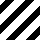
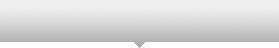
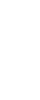
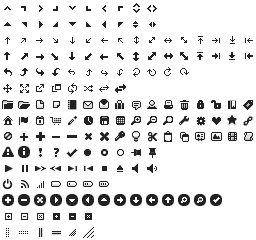
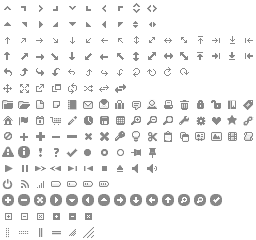
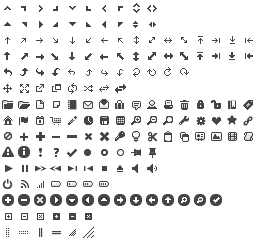
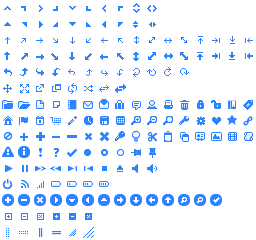
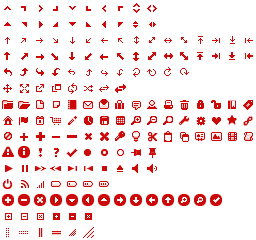
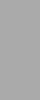
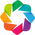
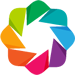
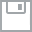
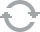
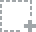
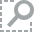
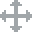
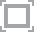
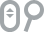

In [1]:
%matplotlib inline

from collections import OrderedDict

import json, codecs
import pandas as pd, numpy as np, matplotlib.pyplot as plt, networkx as nx, seaborn as sns

from bokeh.plotting import *
from bokeh.models import HoverTool, ColumnDataSource

sns.set(style="whitegrid")

In [2]:
page_graph = nx.read_gexf("data/wikipedia-geometry/pages-linked-by-coeditors.gexf")

## adjacency (m1)

### transfomation of the graph into an adjacency matrix

In [3]:
df = pd.DataFrame(columns=["u", "v", "coeditors"])

for u in page_graph.nodes():
    for v in page_graph[u]:
        #print "%s, %s" % (u,v)
        w = page_graph[u][v]["coeditors"]
        u_title = u.split(":")[1]
        v_title = v.split(":")[1]
        new_row = [{ "u": u_title, "v": v_title, "coeditors": w }]
        df = df.append(new_row, ignore_index=True)
        #df = df.append({ "u": u, "v": v, "coeditors": w }, ignore_index=False)

df.head()

,u,v,coeditors
0,Thales' theorem,Minkowski's theorem,9
1,Thales' theorem,Polytope,9
2,Thales' theorem,Group action,14
3,Thales' theorem,Point groups in three dimensions,11
4,Thales' theorem,Parallelepiped,11


In [4]:
pv = df.pivot("u", "v", "coeditors")

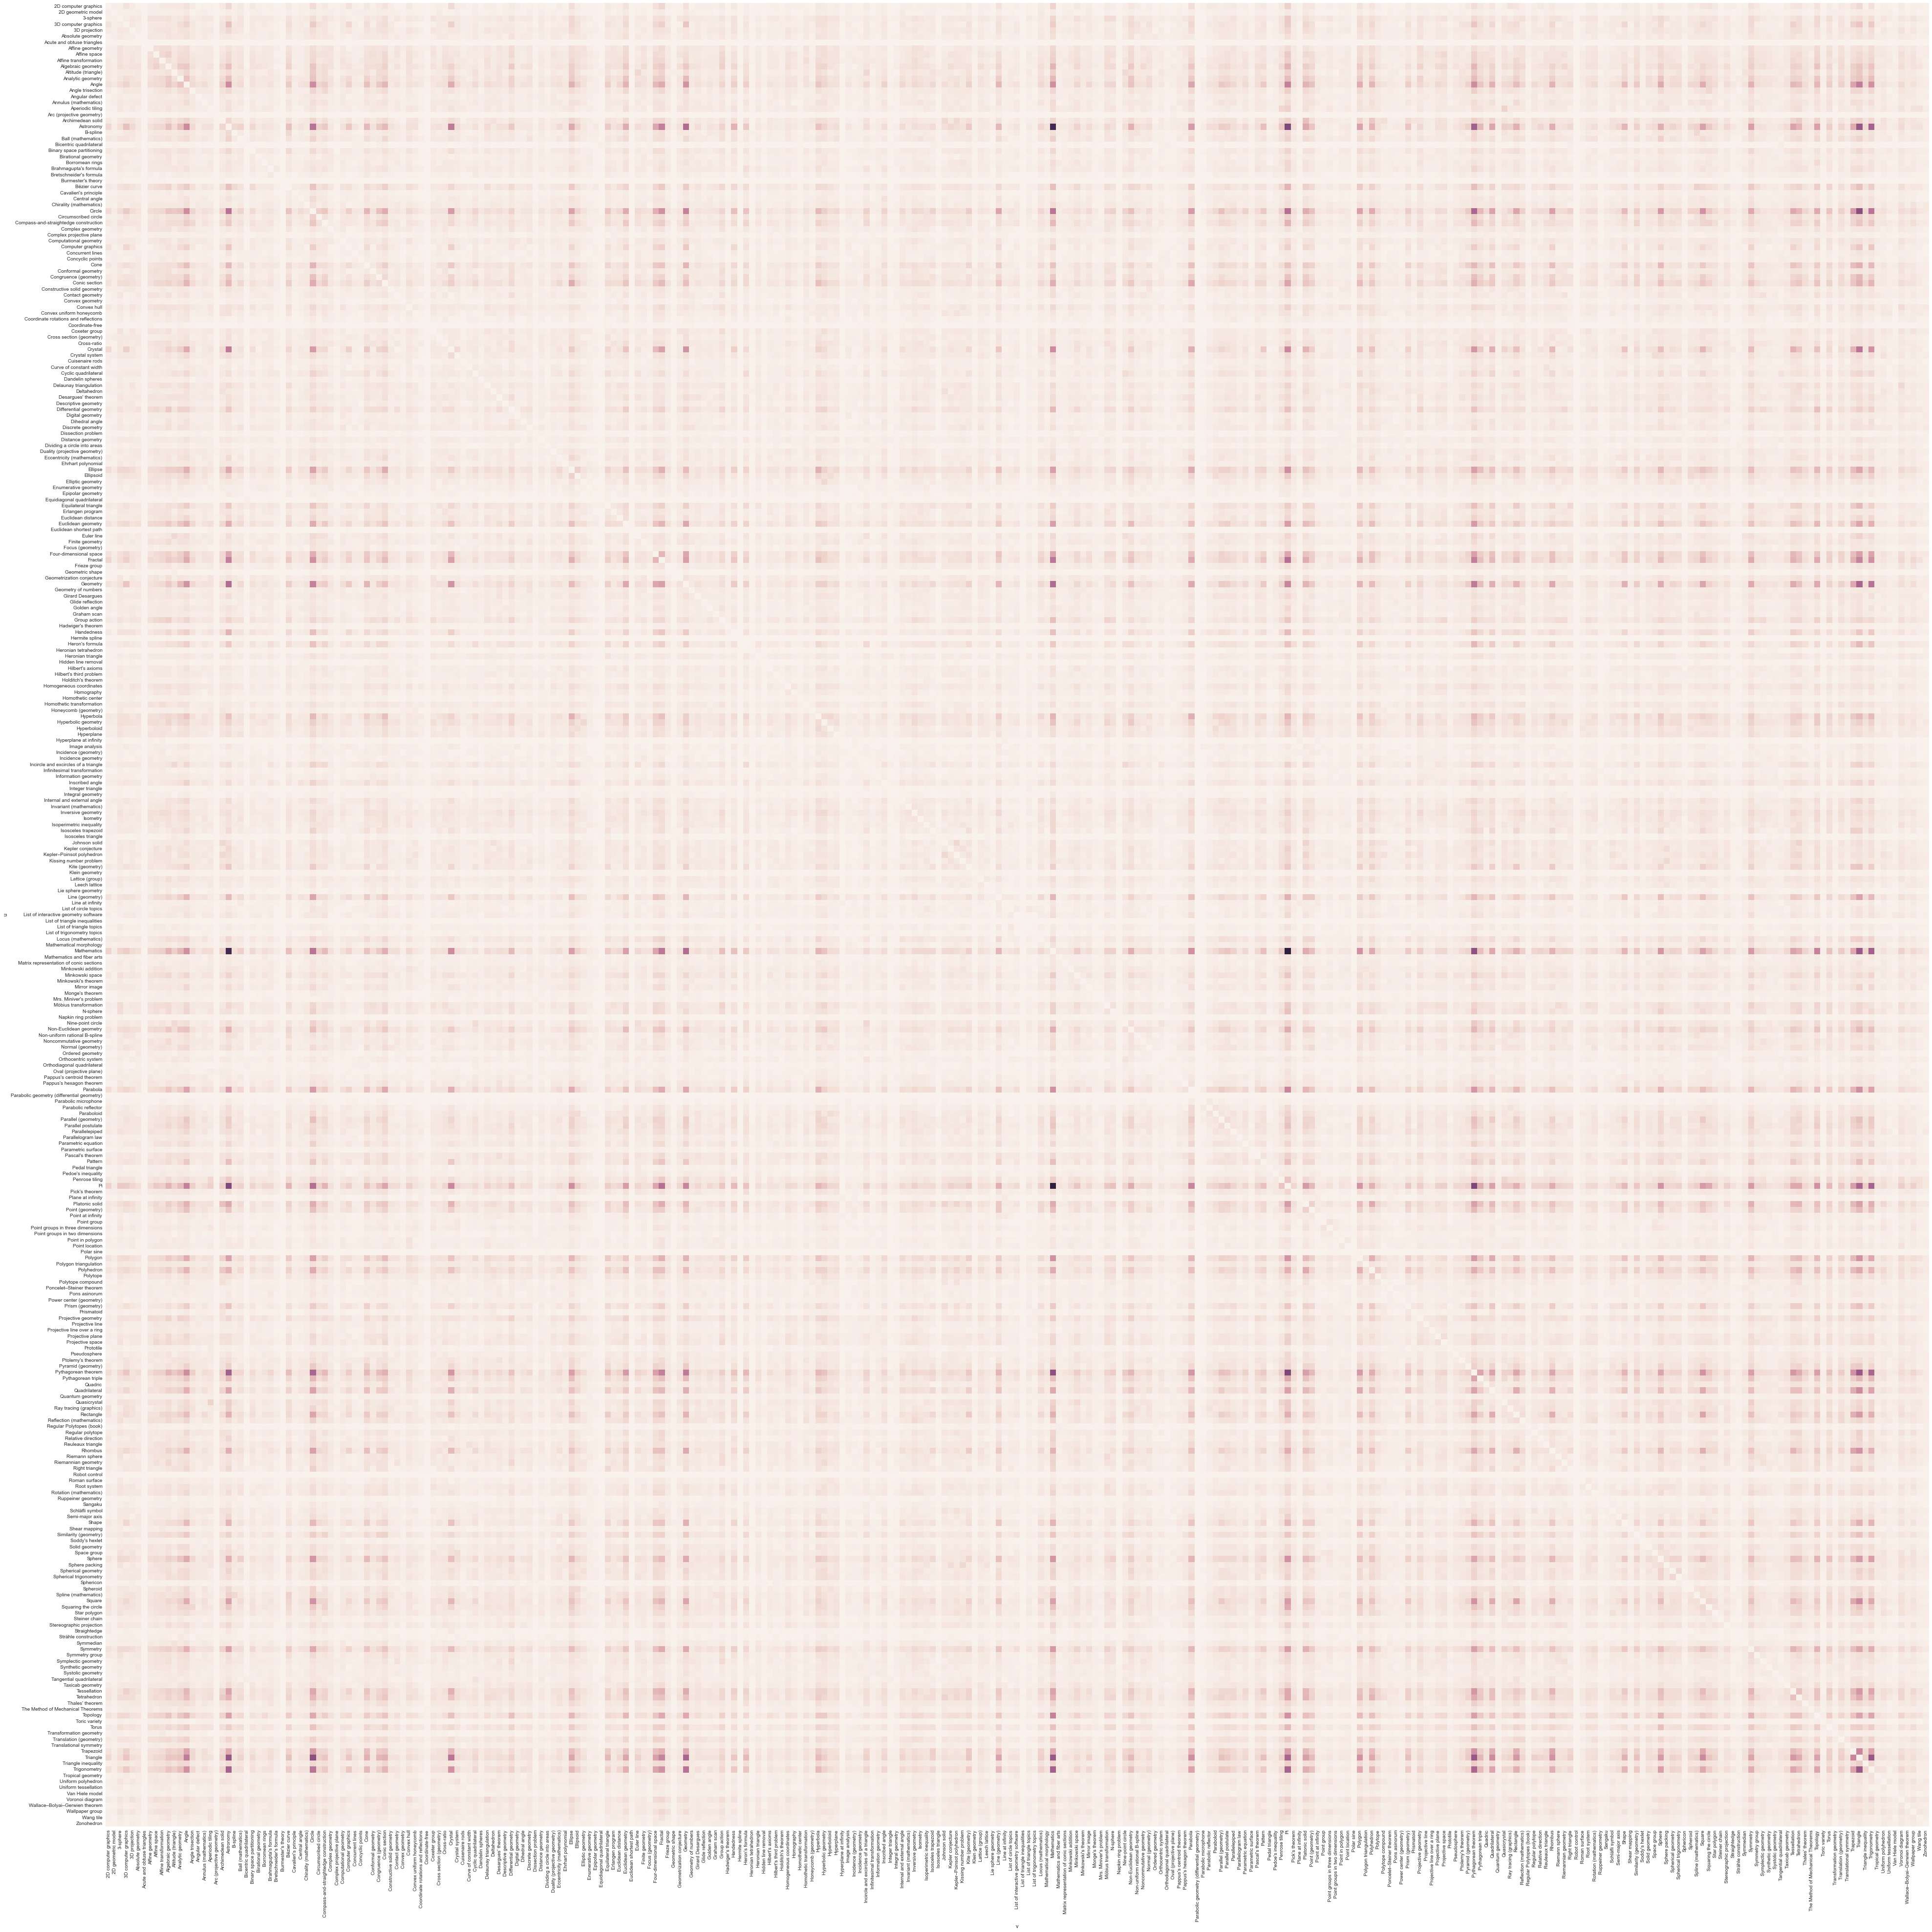

In [6]:
f, ax = plt.subplots(figsize=(55,55))
sns.heatmap(pv, linewidths=0, square=True, cbar=False);
f.tight_layout()

## adjacency (m2: native networkx)

39901/44688 (0.0)


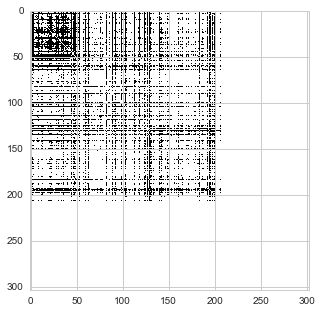

In [7]:
import community 

pages_filtered = page_graph.copy()
ebunch = [ (e[0], e[1]) for e in pages_filtered.edges(data=True) if e[2]["coeditors"] < 20 or e[2]["coeditors"] > 100 ]
#print ebunch
print "%s/%s (%s)" % (len(ebunch), len(page_graph.edges()), float(len(ebunch)/len(page_graph.edges())))

pages_filtered.remove_edges_from(ebunch)

louvain_community_dict = community.best_partition(pages_filtered)

communities = {}
for k, v in louvain_community_dict.iteritems():
    communities.setdefault(v, []).append(k)

def print_groups():
    for c, pages in communities.iteritems():
        print "group %s:" % (c)
        print "---------"

        for p in pages:
            print p.split(":")[1]

        print ""

#print_groups()

ordered_nodes = [ n for c, pages in communities.iteritems() for n in pages ]
#print ordered_nodes
adjacency_matrix = nx.to_numpy_matrix(pages_filtered, nodelist=ordered_nodes)

fig = plt.figure(figsize=(5, 5)) # in inches

plt.imshow(adjacency_matrix, cmap="Greys", interpolation="none")

## adjacency (bokeh)

In [8]:
c = list(nx.k_clique_communities(page_graph, 8))
# print len(c)
# print c

KeyboardInterrupt: 

In [ ]:
o = []
group = {}

print len(c)

for ci, clique in enumerate(c):
    o.extend(list(clique))
    
    for n in list(clique):
        group[n] = ci

print group    
    
# print o
# pv = df.pivot("u", "v", "coeditors")

# f, ax = plt.subplots(figsize=(30,30))
# sns.heatmap(pv, linewidths=0, square=True);
# f.tight_layout()


nodes = o
names = o #[node['name'] for node in sorted(data['nodes'], key=lambda x: x['group'])]

N = len(nodes)
counts = np.zeros((N, N))
for e in page_graph.edges(data=True):
    #print e
    p1 = o.index(e[0])
    p2 = o.index(e[1])

    counts[p1, p2] = e[2]["coeditors"]
    counts[p2, p1] = e[2]["coeditors"]

colormap = [
    "#444444", "#a6cee3", "#1f78b4", "#b2df8a", "#33a02c", "#fb9a99",
    "#e31a1c", "#fdbf6f", "#ff7f00", "#cab2d6", "#6a3d9a"
]

xname = []
yname = []
color = []
alpha = []
for i, n1 in enumerate(nodes):
    for j, n2 in enumerate(nodes):
        xname.append(n1)
        yname.append(n2)

        a = min(counts[i,j]/4.0, 0.9) + 0.1
        alpha.append(a)
#        color.append('lightgrey')

#         if n1['group'] == n2['group']:
#             color.append(colormap[n1['group']])
#         else:
#             color.append('lightgrey')


source = ColumnDataSource(
    data=dict(
        xname=xname,
        yname=yname,
        colors=color,
        alphas=alpha,
        count=counts.flatten(),
    )
)

output_file("page-coeditors.html")


p = figure(x_axis_location="above", tools="resize,hover,save", x_range=list(reversed(o)), y_range=o)
p.plot_width = 1200
p.plot_height = 2000

p.rect('xname', 'yname', 0.9, 0.9, source=source,
     color='colors', alpha='alphas', line_color=None)

p.grid.grid_line_color = None
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.axis.major_label_text_font_size = "5pt"
p.axis.major_label_standoff = 0
p.xaxis.major_label_orientation = np.pi/3

hover = p.select(dict(type=HoverTool))
hover.tooltips = OrderedDict([
    ('names', '@yname, @xname'),
    ('count', '@count'),
])

show(p) # show the plot

# final report